* Name: `dissipation-theory--Study-7.ipynb`
* Author: John A. Marohn
* Date: 2023-10-02
* Continued from: `dissipation-theory--Study-6.ipynb`
* Continued to: --
* Reproduce the friction $\gamma_{\perp}$ versus charge density $\rho$ plots in Lekkala2013 Figure 9(b) using functions in `dissipationtheory.dissipation.py`.  The computation below is carried out over 40 charge densities and 5 values of the imaginary dielectric constant $\epsilon_{\mathrm{s}}^{\prime \prime}$, using a `numba`-compiled Python version of Model II in the paper.  The computation takes less than a second.  In the paper, the tip-sample separation $d$ was not specified. A first computation was done with $d = 300 \: \mathrm{\mu m}$, but the agreement with Lekkala was poor.  The tip-sample separation was varied between 30 nm and 300 nm in 1 nm increments and the sum-squared deviation $\chi^2$ between the computed dissipation and Lekkala's dissipation calculated for the $\epsilon_{\mathrm{s}}^{\prime \prime} = 0$ case.  The $\chi^2$ was minimized at an optimal tip-sample separation of $d_{\mathrm{opt}} = 66.0 \: \mathrm{nm}$.  Computations performed with $d = d_{\mathrm{opt}}$ were in semi-quanitative agreement with Lekkala over a range of $\epsilon_{\mathrm{s}}^{\prime \prime}$ values. 

# Preliminaries

In [1]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation import CantileverModelJit, SampleModel2Jit
from dissipationtheory.dissipation import theta2norm_jit, gamma_perpendicular_jit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
THIS = 'dissipation-theory--Study-7'

# Read in and plot data

In [4]:
keys = ['0.000','0.005','0.050','0.100','0.500']

names = ['Lekkala2013--Fig9b--0.000.csv', 
         'Lekkala2013--Fig9b--0.005.csv',
         'Lekkala2013--Fig9b--0.050.csv',
         'Lekkala2013--Fig9b--0.100.csv',
         'Lekkala2013--Fig9b--0.500.csv']

Figure9b_original = {}
for key, name in zip(keys, names):
    Figure9b_original[key] = pd.read_csv(name, names=['rho', 'gamma'])

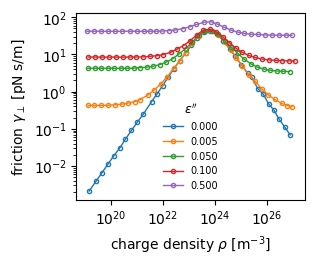

In [5]:
plt.figure(figsize=(3.25, 2.75))

for key in Figure9b_original.keys():
    plt.loglog(Figure9b_original[key]['rho'],Figure9b_original[key]['gamma'], 
               marker='o', markersize=3, fillstyle='none', linestyle='-', linewidth=1, label=key)

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.legend(fontsize=7, frameon=False, title='$\epsilon^{\prime\prime}$', title_fontsize=9)
plt.tight_layout()

plt.savefig(THIS + '--Fig-1.png', dpi=300)
plt.savefig(THIS + '--Fig-1.pdf')

plt.show()

# Simulation (Try 1)

In the Lekkala 2013 Figure 9 simulations, the tip-sample separation was, frustratingly, not reported.  Assume $d = 300 \: \mathrm{\mu m}$, the tip-sample sepration reportedly used in the paper's Figure 7 simulations.

In [6]:
sample2_jit = SampleModel2Jit(
    cantilever=CantileverModelJit(81.0e3, 3.,  40E-9, 300E-9),
    epsilon_d=complex(3.4,-0.05),
    h_d=69E-9,
    epsilon_s=complex(3.4,-0.05),
    mu=2.7E-10,
    rho=1e21,
    z_r=300E-9)

In [7]:
(sample2_jit.cantilever.d, sample2_jit.z_r)

(3e-07, 3e-07)

In [8]:
sample2_jit.print()

cantilever
   cantilever freq =  81000.0 Hz
                   =  508938.0098815465 rad/s
tip-sample voltage =  3.0 V
            radius =  4e-08 m
            height =  3e-07 m

dielectric
 epsilon (real) =  3.4
 epsilon (imag) =  -0.05
      thickness =  6.9e-08 m

semiconductor
          epsilon (real) =  3.4
          epsilon (imag) =  -0.05
               thickness = infinite
                mobility =  2.7e-10 m^2/(V s)
      diffusion constant =  6.980039959763987e-12 m^2/s
          charge density =  1e+21 m^{{-3}}
        reference height =  3e-07 m
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  3.7033649406515185e-09 m
effective epsilon (real) =  3.4
effective epsilon (imag) =  -0.059599763628316975


Spot-check the integrand.

In [9]:
theta2norm_jit(1, sample2_jit, 2)

-0.0007828858140009441

Spot-check the friction.

In [10]:
gamma_perpendicular_jit(theta2norm_jit, sample2_jit).to('pN s/m')

Magnitude,[0.08340826831046526]
Units,piconewton second/meter


Calculation friction versus charge density, for various values of the imaginary part of the dielectric constant.

In [11]:
rho1 = ureg.Quantity(np.logspace(start=19, stop=27, num=40), '1/m^3')

In [12]:
Figure9b_sample2_jit = {}

for epsilonI_ in [0.000, 0.005, 0.050, 0.100, 0.500]:

    key = '{:0.3f}'.format(epsilonI_)

    sample2_jit.epsilon_d = complex(3.4, -1 * epsilonI_)
    sample2_jit.epsilon_s = complex(3.4, -1 * epsilonI_)
    
    result2 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }
    
    for index, rho_ in tqdm(enumerate(rho1)):

        sample2_jit.rho = rho_.to('1/m^3').magnitude
        
        result2['gamma'][index] = gamma_perpendicular_jit(theta2norm_jit, sample2_jit).to('pN s/m')

    Figure9b_sample2_jit[key] = result2

40it [00:00, 87.90it/s] 
40it [00:00, 108.87it/s]
40it [00:00, 123.35it/s]
40it [00:00, 125.73it/s]
40it [00:04,  9.23it/s]


Make sure the keys in `Figure9b_sample2_jit` agree with the keys in `Figure9b_original`.

In [13]:
print(Figure9b_original.keys())
print(Figure9b_sample2_jit.keys())

dict_keys(['0.000', '0.005', '0.050', '0.100', '0.500'])
dict_keys(['0.000', '0.005', '0.050', '0.100', '0.500'])


Plot the data alongside my simulations.

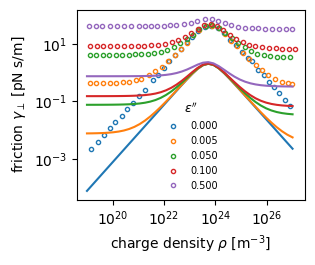

In [14]:
plt.figure(figsize=(3.25, 2.75))

for key, c in zip(Figure9b_original.keys(), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']):

    plt.loglog(Figure9b_original[key]['rho'],
               Figure9b_original[key]['gamma'], 
               marker='o', markersize=3, fillstyle='none', linestyle='none', color=c, label=key)
    
    plt.loglog(Figure9b_sample2_jit[key]['rho'].to('1/m^3').magnitude,
              Figure9b_sample2_jit[key]['gamma'].to('pN s/m').magnitude,
              '-', color=c)

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.legend(fontsize=7, frameon=False, title='$\epsilon^{\prime\prime}$', title_fontsize=9)
plt.tight_layout()

plt.savefig(THIS + '--Fig-2.png', dpi=300)
plt.savefig(THIS + '--Fig-2.pdf')

plt.show()

We see the right friction versus charge density trend, but the predicted friction is much smaller that Lekkala's.

# Allow the tip radius to vary

In [15]:
distance = np.linspace(start=30E-9, stop=300E-9, num=271)
rho2 = ureg.Quantity(np.array(Figure9b_original['0.000']['rho']), '1/m^3')

In [16]:
calculated = {}

for distance_ in distance:
    
    sample2_jit.cantilever.d = distance_
    sample2_jit.z_r = distance_
    sample2_jit.epsilon_d = complex(3.4, 0.)
    sample2_jit.epsilon_s = complex(3.4, 0.)
    
    result2 = ureg.Quantity(np.zeros_like(rho2), 'pN s/m')
    
    for index, rho_ in enumerate(rho2):

        sample2_jit.rho = rho_.to('1/m^3').magnitude
        result2[index] = gamma_perpendicular_jit(theta2norm_jit, sample2_jit).to('pN s/m')

    calculated[distance_] = {'distance': ureg.Quantity(distance_, 'm'), 'gamma': result2}

In [17]:
chisq = np.zeros_like(distance)
y_meas = np.array(Figure9b_original['0.000']['gamma'])
for index, distance_ in enumerate(distance):

    y_calc = calculated[distance_]['gamma'].to('pN s/m').magnitude
    chisq[index] = np.power(y_calc - y_meas, 2.0).sum()
    # print('radius = {:5.1f}, chisq = {:0.2e}'.format(calculated[distance_]['distance'].to('nm').magnitude, chisq[index]))

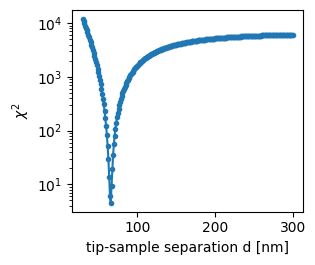

In [18]:
plt.figure(figsize=(3.25, 2.75))
plt.semilogy(1e9 * distance, chisq, '.-')
plt.xlabel('tip-sample separation d [nm]')
plt.ylabel('$\chi^2$')
plt.tight_layout()

plt.savefig(THIS + '--Fig-3.png', dpi=300)
plt.savefig(THIS + '--Fig-3.pdf')

plt.show()

The best agreement occurs at a distance of

In [19]:
d_opt = distance[np.argmin(chisq)]
print('{:3.1f} nm'.format(1e9 * d_opt))

66.0 nm


# Simulation (Try 2)

Redo the simulation with the best-fit radius determined above.

In [20]:
sample2_jit = SampleModel2Jit(
    cantilever=CantileverModelJit(81.0e3, 3.,  40E-9, d_opt),
    epsilon_d=complex(3.4,-0.05),
    h_d=69E-9,
    epsilon_s=complex(3.4,-0.05),
    mu=2.7E-10,
    rho=1e21,
    z_r=d_opt)

In [21]:
sample2_jit.print()

cantilever
   cantilever freq =  81000.0 Hz
                   =  508938.0098815465 rad/s
tip-sample voltage =  3.0 V
            radius =  4e-08 m
            height =  6.600000000000001e-08 m

dielectric
 epsilon (real) =  3.4
 epsilon (imag) =  -0.05
      thickness =  6.9e-08 m

semiconductor
          epsilon (real) =  3.4
          epsilon (imag) =  -0.05
               thickness = infinite
                mobility =  2.7e-10 m^2/(V s)
      diffusion constant =  6.980039959763987e-12 m^2/s
          charge density =  1e+21 m^{{-3}}
        reference height =  6.600000000000001e-08 m
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  3.7033649406515185e-09 m
effective epsilon (real) =  3.4
effective epsilon (imag) =  -0.059599763628316975


Redo the simulation for different $\epsilon_{\mathrm{s}}^{\prime\prime}$ values.

In [22]:
Figure9b_sample2_jit = {}

for epsilonI_ in [0.000, 0.005, 0.050, 0.100, 0.500]:

    key = '{:0.3f}'.format(epsilonI_)

    sample2_jit.epsilon_d = complex(3.4, -1 * epsilonI_)
    sample2_jit.epsilon_s = complex(3.4, -1 * epsilonI_)
    
    result2 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }
    
    for index, rho_ in tqdm(enumerate(rho1)):

        sample2_jit.rho = rho_.to('1/m^3').magnitude
        
        result2['gamma'][index] = gamma_perpendicular_jit(theta2norm_jit, sample2_jit).to('pN s/m')

    Figure9b_sample2_jit[key] = result2

40it [00:00, 55.29it/s]
40it [00:00, 46.04it/s]
40it [00:01, 27.24it/s]
40it [00:01, 28.34it/s]
40it [00:00, 42.07it/s]


Replot the data and simulation, computed using this optimal tip-sample separation.

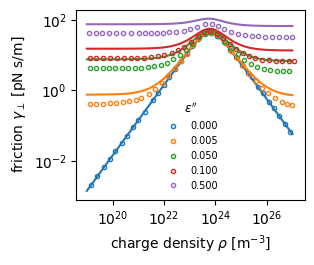

In [23]:
plt.figure(figsize=(3.25, 2.75))

for key, c in zip(Figure9b_original.keys(), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']):

    plt.loglog(Figure9b_original[key]['rho'],
               Figure9b_original[key]['gamma'], 
               marker='o', markersize=3, fillstyle='none', linestyle='none', color=c, label=key)
    
    plt.loglog(Figure9b_sample2_jit[key]['rho'].to('1/m^3').magnitude,
              Figure9b_sample2_jit[key]['gamma'].to('pN s/m').magnitude,
              '-', color=c)

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.legend(fontsize=7, frameon=False, title='$\epsilon^{\prime\prime}$', title_fontsize=9)
plt.tight_layout()

plt.savefig(THIS + '--Fig-4.png', dpi=300)
plt.savefig(THIS + '--Fig-4.pdf')

plt.show()

The agreement has improved.

# Reoptimize the tip radius

Instead of minimizing $\chi^2$ using the $\epsilon_{\mathrm{s}}^{\prime\prime} = 0$ dataset, minimize it over all five data sets.  Furthermore, let us minimize the relative error, not the absolute error.  This will give all the curves equal weight, even though they have quite different peak $\gamma_{\perp}$ values.

Compute $\gamma_{\perp}$ versus $\rho$ at $\rho$ values drawn from the `csv` Lekkala Figure 9(b) data read above.  Do this computation at the five $\epsilon_{\mathrm{s}}^{\prime\prime}$ values and at various values of the tip-sample spacing $d$. The following calculation takes a few minutes.

In [24]:
distance = np.linspace(start=50E-9, stop=100E-9, num=51)
calculated = {}

for epsilonI_ in [0.000, 0.005, 0.050, 0.100, 0.500]:

    key = '{:0.3f}'.format(epsilonI_)
    rho2 = ureg.Quantity(np.array(Figure9b_original[key]['rho']), '1/m^3')

    for distance_ in distance:
        
        sample2_jit.cantilever.d = distance_
        sample2_jit.z_r = distance_
        sample2_jit.epsilon_d = complex(3.4, -1 * epsilonI_)
        sample2_jit.epsilon_s = complex(3.4, -1 * epsilonI_)
        
        result2 = ureg.Quantity(np.zeros_like(rho2), 'pN s/m')
        
        for index, rho_ in enumerate(rho2):
    
            sample2_jit.rho = rho_.to('1/m^3').magnitude
            result2[index] = gamma_perpendicular_jit(theta2norm_jit, sample2_jit).to('pN s/m')
    
        calculated[distance_] = {key: {'distance': ureg.Quantity(distance_, 'm'), 'gamma': result2}}

Now compute a $\chi^2$ by averaging over the *normalized* residuals across the five data sets.

In [25]:
chisq = np.zeros_like(distance)
for index, distance_ in enumerate(distance):

    chisq[index] = 0
    for keys in calculated:
        
        y_meas = np.array(Figure9b_original[key]['gamma'])
        y_calc = calculated[distance_][key]['gamma'].to('pN s/m').magnitude
        
        chisq[index] = chisq[index] + np.power((y_calc - y_meas)/y_meas, 2.0).sum()

Plot the resulting $\chi^2$ versus tip-sample separation.

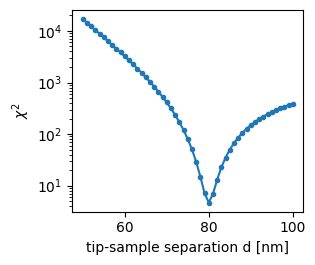

In [26]:
plt.figure(figsize=(3.25, 2.75))
plt.semilogy(1e9 * distance, chisq, '.-')
plt.xlabel('tip-sample separation d [nm]')
plt.ylabel('$\chi^2$')
plt.tight_layout()

plt.savefig(THIS + '--Fig-5.png', dpi=300)
plt.savefig(THIS + '--Fig-5.pdf')

plt.show()

Find the distance at which the $\chi^2$ function is minimized.

In [27]:
d_opt2 = distance[np.argmin(chisq)]
print('{:3.1f} nm'.format(1e9 * d_opt2))

80.0 nm


# Simulation (Try 3)

Resimulate the data using the new optimal tip-sample separation, $d =80.0 \: \mathrm{nm}$.

In [28]:
sample2_jit = SampleModel2Jit(
    cantilever=CantileverModelJit(81.0e3, 3.,  40E-9, d_opt2),
    epsilon_d=complex(3.4,-0.05),
    h_d=69E-9,
    epsilon_s=complex(3.4,-0.05),
    mu=2.7E-10,
    rho=1e21,
    z_r=d_opt)

In [29]:
Figure9b_sample2_jit = {}

for epsilonI_ in [0.000, 0.005, 0.050, 0.100, 0.500]:

    key = '{:0.3f}'.format(epsilonI_)

    sample2_jit.epsilon_d = complex(3.4, -1 * epsilonI_)
    sample2_jit.epsilon_s = complex(3.4, -1 * epsilonI_)
    
    result2 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }
    
    for index, rho_ in tqdm(enumerate(rho1)):

        sample2_jit.rho = rho_.to('1/m^3').magnitude
        
        result2['gamma'][index] = gamma_perpendicular_jit(theta2norm_jit, sample2_jit).to('pN s/m')

    Figure9b_sample2_jit[key] = result2

40it [00:00, 63.81it/s]
40it [00:00, 82.09it/s]
40it [00:00, 49.09it/s]
40it [00:00, 90.78it/s]
40it [00:00, 87.83it/s]


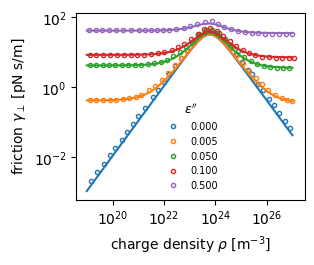

In [30]:
plt.figure(figsize=(3.25, 2.75))

for key, c in zip(Figure9b_original.keys(), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']):

    plt.loglog(Figure9b_original[key]['rho'],
               Figure9b_original[key]['gamma'], 
               marker='o', markersize=3, fillstyle='none', linestyle='none', color=c, label=key)
    
    plt.loglog(Figure9b_sample2_jit[key]['rho'].to('1/m^3').magnitude,
              Figure9b_sample2_jit[key]['gamma'].to('pN s/m').magnitude,
              '-', color=c)

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.legend(fontsize=7, frameon=False, title='$\epsilon^{\prime\prime}$', title_fontsize=9)
plt.tight_layout()

plt.savefig(THIS + '--Fig-6.png', dpi=300)
plt.savefig(THIS + '--Fig-6.pdf')

plt.show()

The overall agreement has been improved significantly.